<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/250px-Jupyter_logo.svg.png" alt="Jupyter Logo" width="100">

### Student Performance Prediction

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[Click here to see the data in Kaggle.com](https://www.kaggle.com/datasets/rkiattisak/student-performance-in-mathematics?datasetId=2969333)

In [4]:
data = pd.read_csv("exams.csv")

print(data.head())

   gender race/ethnicity parental level of education         lunch   
0  female        group D                some college      standard  \
1    male        group D          associate's degree      standard   
2  female        group D                some college  free/reduced   
3    male        group B                some college  free/reduced   
4  female        group D          associate's degree      standard   

  test preparation course  math score  reading score  writing score  
0               completed          59             70             78  
1                    none          96             93             87  
2                    none          57             76             77  
3                    none          70             70             63  
4                    none          83             85             86  


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


In [6]:
print("Unique categories")
print("Number of unique 'gender' categories:",data["gender"].nunique())
print("Number of unique 'race/ethnicity' categories:",data["race/ethnicity"].nunique())
print("Number of unique 'parental level of education' categories:",data["parental level of education"].nunique())
print("Number of unique 'lunch' categories:",data["lunch"].nunique())
print("Number of unique 'test preparation course' categories:",data["test preparation course"].nunique())

Unique categories
Number of unique 'gender' categories: 2
Number of unique 'race/ethnicity' categories: 5
Number of unique 'parental level of education' categories: 6
Number of unique 'lunch' categories: 2
Number of unique 'test preparation course' categories: 2


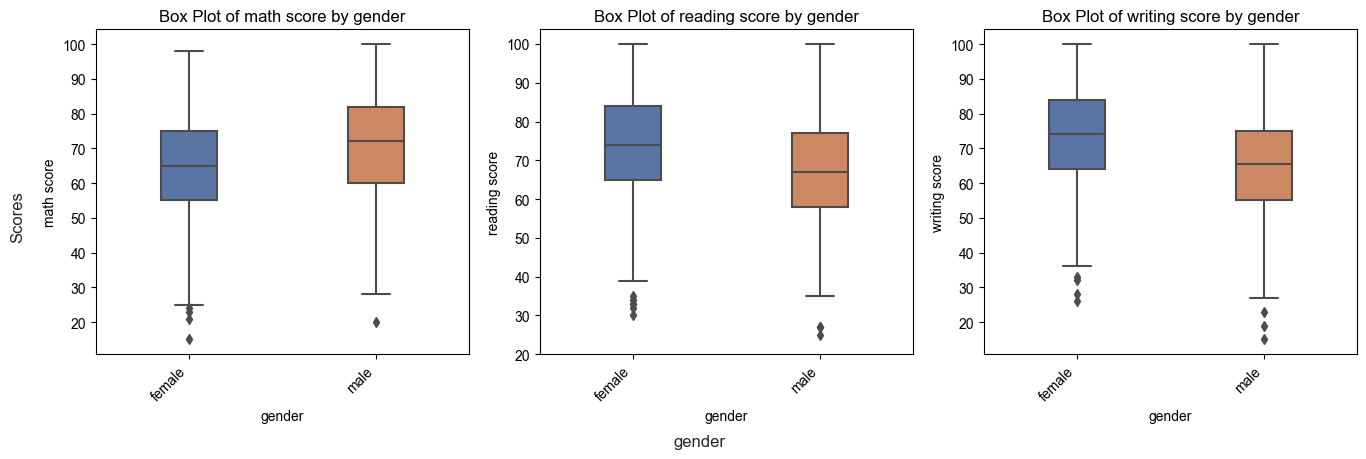

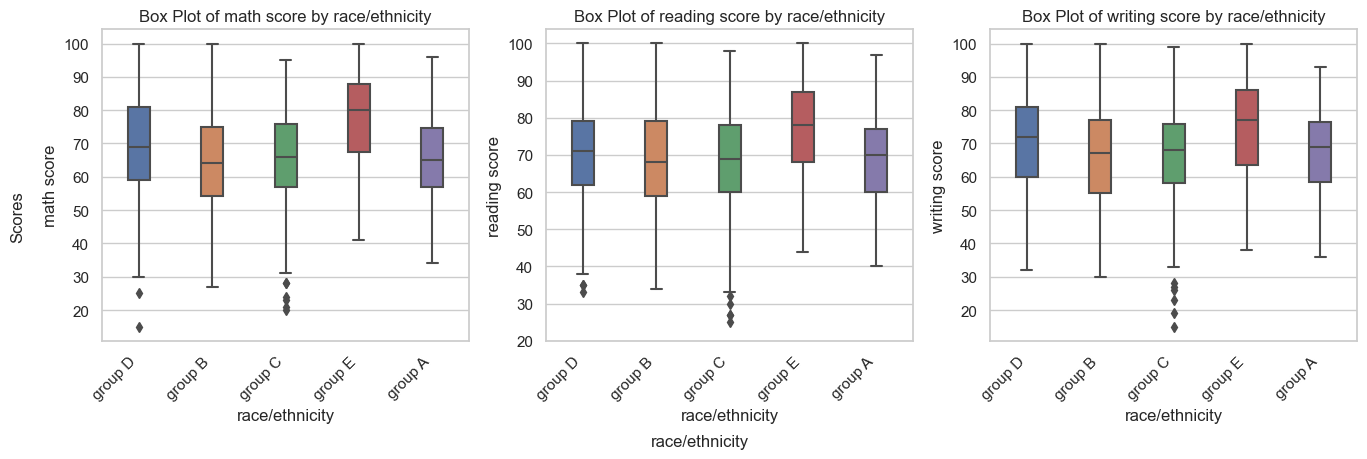

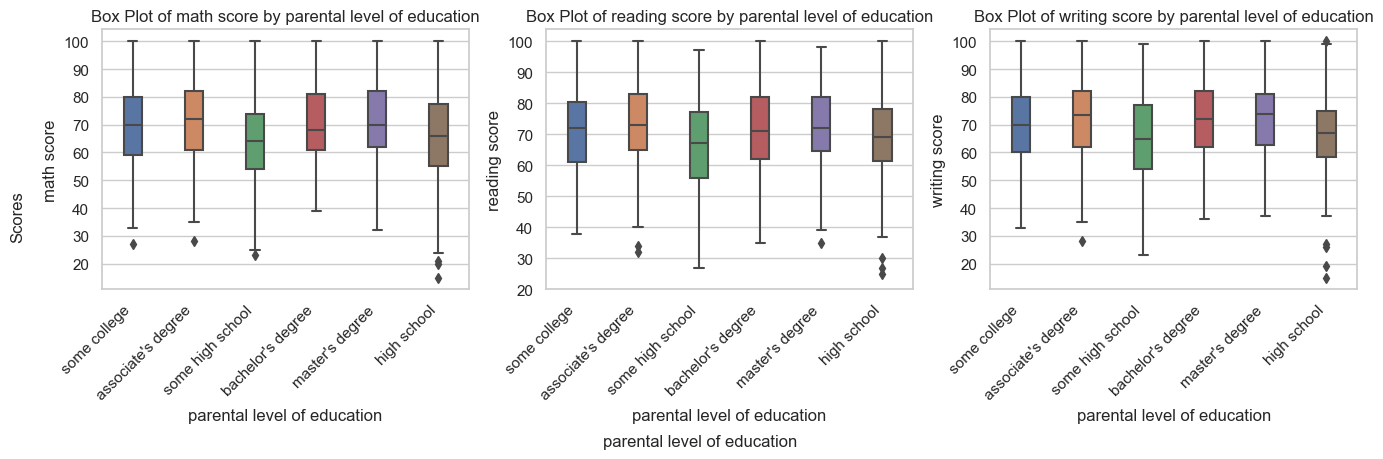

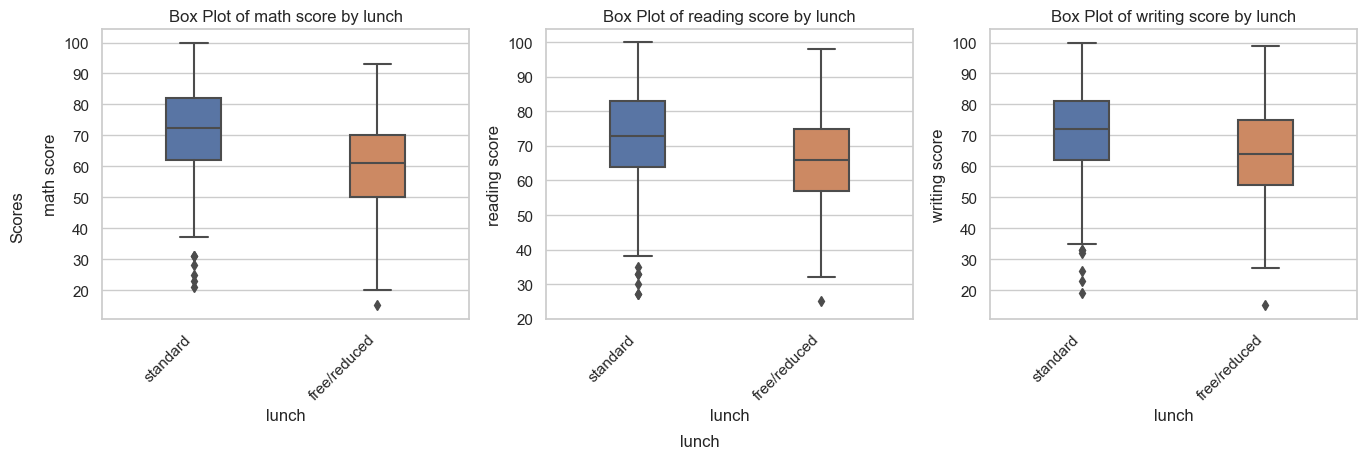

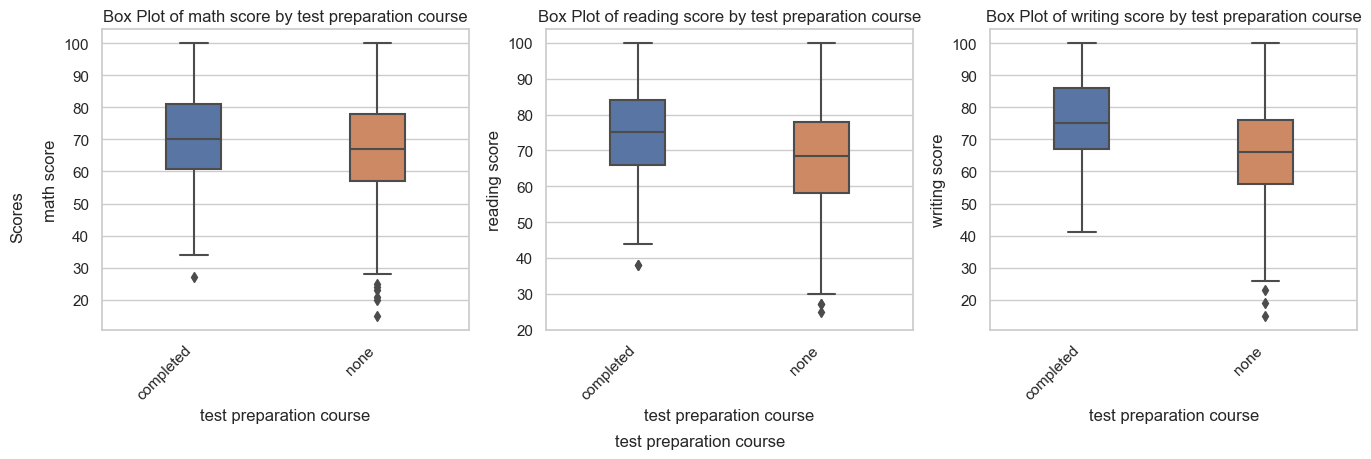

In [7]:
def plot_boxplots(data, categorical_column, numerical_columns):
    """
    Plot boxplots for the given categorical_column against each of the numerical_columns.
    
    Parameters:
    data: DataFrame containing the data
    categorical_column: The column name for which box plots will be made
    numerical_columns: List of numerical column names for Y-axis
    """
    
    # Create a new figure and a grid of subplots
    fig, axes = plt.subplots(1, len(numerical_columns), figsize=(15, 5))
    
    # Set overall aesthetics
    sns.set(style="whitegrid")
    # Grid
    ymin = data[numerical_columns].min().min()
    ymax = data[numerical_columns].max().max()
    yticks_grid = np.arange(ymin+5, ymax+1, 10) # Interval of 10
    
    for ax, num_col in zip(axes, numerical_columns):
        sns.boxplot(x=categorical_column, y=num_col, data=data, width=0.3, ax=ax)
        ax.set_title(f"Box Plot of {num_col} by {categorical_column}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_yticks(yticks_grid)
    
    # Add common x-label and y-label
    fig.text(0.5, 0.04, categorical_column, ha='center')
    fig.text(0.04, 0.5, 'Scores', va='center', rotation='vertical')
    
    # Show the plot
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    plt.show()


# Assuming you want to plot boxplots for int64 columns against each object type column
for cat_col in data.select_dtypes(include=["object"]).columns:
    numerical_columns = data.select_dtypes(include=["int64"]).columns.tolist()
    plot_boxplots(data, cat_col, numerical_columns)

### Notes about the data

- On average, males outperform females in math, while females excel in reading and writing.
- Group E consistently has the highest average scores across all tests.
- There is no significant difference in test scores based on parental education level.
- The 'Standard' group, which pays for its own lunch, generally performs better across all tests.
- Test preparation has a more pronounced impact on reading and writing scores, while its effect on math scores is less noticeable.

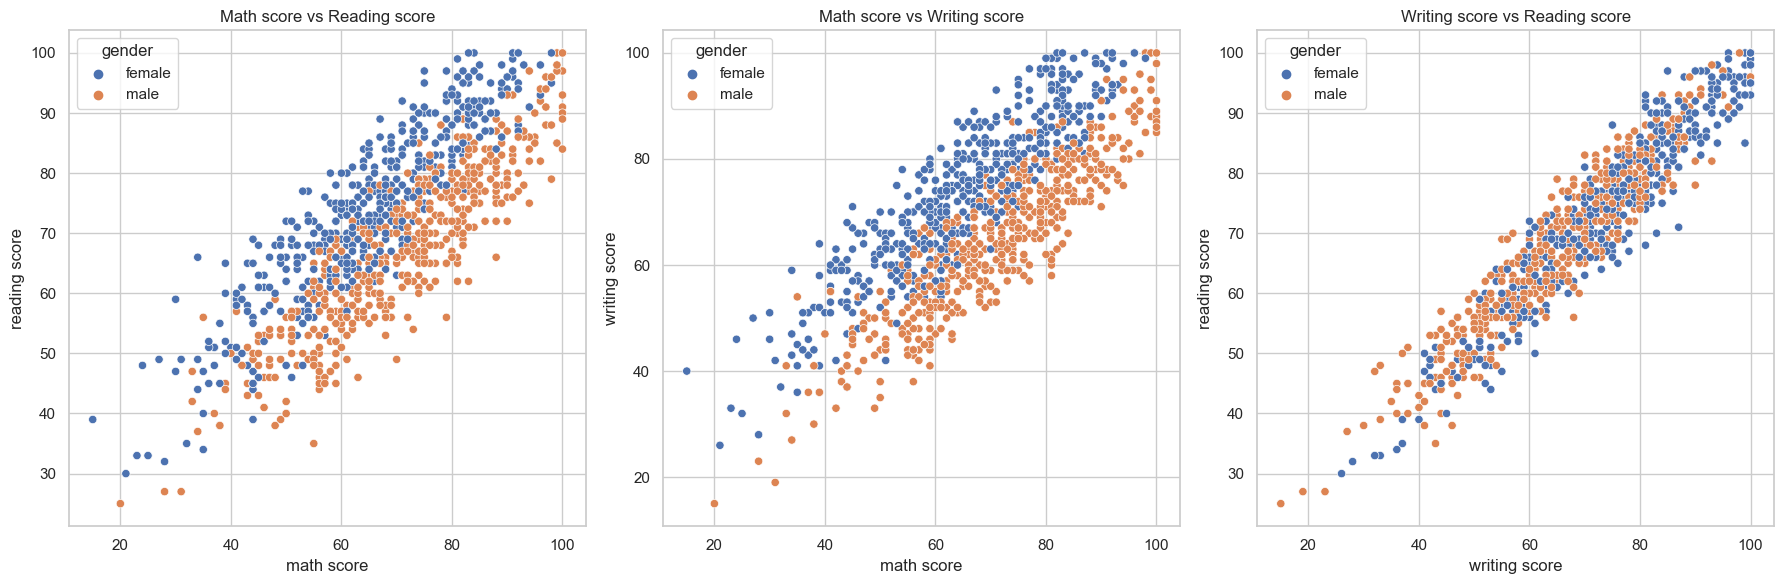

In [8]:
# Correlation between test scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=data, x="math score", y="reading score", hue="gender", ax=axes[0])
axes[0].set_title("Math score vs Reading score")

sns.scatterplot(data=data, x="math score", y="writing score", hue="gender", ax=axes[1])
axes[1].set_title("Math score vs Writing score")

sns.scatterplot(data=data, x="writing score", y="reading score", hue="gender", ax=axes[2])
axes[2].set_title("Writing score vs Reading score")

plt.tight_layout()
plt.show()

### Project plan 

- Let's pick up 'race/ethnicity' as the target category for the machine learning model. However, the data seems challenging because box plots show hardly any difference, and numerical values are highly correlated. Since there are five different categories within the 'race/ethnicity' group, anything over 20% accuracy is better than a guess.

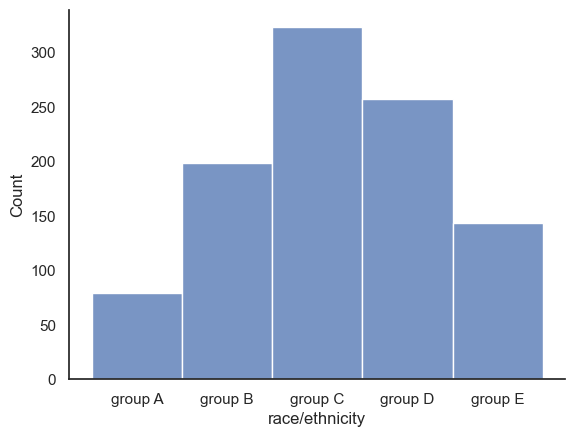

In [9]:
sns.set_style("white")

data = data.sort_values(by="race/ethnicity")

sns.histplot(data=data, x="race/ethnicity", discrete=True)
sns.despine()
plt.show()

### Random Forest Classifier

#### Data preprosessing

In [10]:
# Initialize the label encoder
le = LabelEncoder()

# Convert each categorical column to numeric
for col in data.select_dtypes(include=['object']).columns:
    data[col] = le.fit_transform(data[col])

In [11]:
# Split target
y = data["race/ethnicity"]
x = data.drop(columns="race/ethnicity")

In [12]:
# Split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [13]:
# ML model
rfc = RandomForestClassifier()

In [14]:
# Hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [76, 78, 80],
    'max_depth': [7, 8, 9],
    'min_samples_split': [5 ,6, 7],
    'min_samples_leaf': [6, 7, 8]
}

In [15]:
# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5, verbose=2, n_jobs=-1) #n_jobs = -1 to use all cores.
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12],
                         'min_samples_leaf': [5, 6, 7],
                         'min_samples_split': [6, 7, 8],
                         'n_estimators': [72, 75, 78]},
             verbose=2)

In [16]:
# Best parameters
best_params = grid_search.best_params_
# Best rfc model with the parameters
best_rfc = grid_search.best_estimator_

In [17]:
for key, value in best_params.items():
    print("Optimal hyperparameter for", key, "is", value)

Optimal hyperparameter for max_depth is 8
Optimal hyperparameter for min_samples_leaf is 7
Optimal hyperparameter for min_samples_split is 6
Optimal hyperparameter for n_estimators is 78


In [18]:
y_pred = best_rfc.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.3500


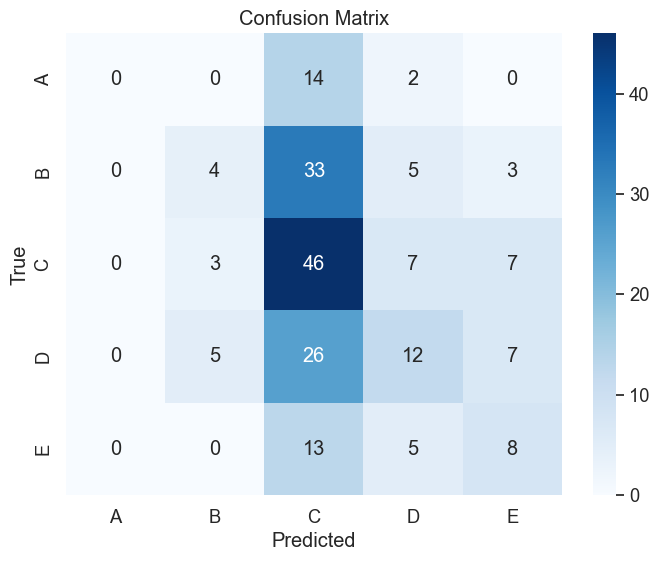

In [19]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = ["A", "B", "C", "D", "E"]
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.33      0.09      0.14        45
           2       0.35      0.73      0.47        63
           3       0.39      0.24      0.30        50
           4       0.32      0.31      0.31        26

    accuracy                           0.35       200
   macro avg       0.28      0.27      0.24       200
weighted avg       0.32      0.35      0.30       200



C:\Users\Toni\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Toni\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Toni\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Extreme gradient boost

In [44]:
from xgboost import XGBClassifier
# XGB classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

C:\Users\Toni\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [45]:
# Hyperparameter grid to search
param_grid = {
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [25, 50, 75],
    'max_depth': [2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8, 1]
}

In [46]:
grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(x_train, y_train)

C:\Users\Toni\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Toni\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.005, 0.01, 0.05],
                         'max_depth': [2, 3, 4], 'n_estimators': [25, 50, 75],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=2)

In [47]:
best_params_xgb = grid_search.best_params_
best_clf = grid_search.best_estimator_
test_score = best_clf.score(x_test, y_test)
print(f"Test set accuracy: {test_score:.2f}")

Test set accuracy: 0.33


In [48]:
for key, value in best_params_xgb.items():
    print("Optimal hyperparameter for", key, "is", value)

Optimal hyperparameter for colsample_bytree is 1
Optimal hyperparameter for learning_rate is 0.01
Optimal hyperparameter for max_depth is 2
Optimal hyperparameter for n_estimators is 75
Optimal hyperparameter for subsample is 0.8


In [49]:
y_pred = best_clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.3300
